In [1]:
!pip install mitdeeplearning
import mitdeeplearning as mdl

     |████████████████████████████████| 2.1 MB 2.9 MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-py3-none-any.whl size=2115443 sha256=54150b77bef476faaf3952d0760a18824c6ddee81379f0d6e7b5e80a421b4450
  Stored in directory: /root/.cache/pip/wheels/9a/b9/4f/99b7c8c5c75355550b83e1fcfc02956fb40c35eb01e2262877
Successfully built mitdeeplearning


In [2]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow.keras import layers as L
import tensorflow.keras.preprocessing.image as imgPrep
import os
import pandas as pd
from tensorflow.keras.utils import plot_model

###Constant###
LATENT_EPOCHS = 25
SMOOTHING_FAC = 0

In [3]:
data_path = r'../input/melanoma-h5-dataset/short_data.h5'
cache = h5py.File(data_path, 'r')
images = cache['images'][:]

In [4]:
labels = cache['labels'][:].astype(np.float32)
labels = labels.reshape(-1, 1)

In [5]:
number_of_training_examples = images.shape[0]
image_dims = images.shape
n_train_samples = image_dims[0]
train_inds = np.random.permutation(np.arange(n_train_samples))
pos_train_inds = train_inds[labels[train_inds, 0] == 1.0 ]
neg_train_inds = train_inds[labels[train_inds, 0] != 1.0 ]

In [6]:
def get_batch(n, only_faces=False, p_pos=None, p_neg=None, return_inds=False):
    if only_faces:
            selected_inds = np.random.choice(pos_train_inds, size=n, replace=False, p=p_pos)
    else:
        selected_pos_inds = np.random.choice(pos_train_inds, size=n//2, replace=False, p=p_pos)
        selected_neg_inds = np.random.choice(neg_train_inds, size=n//2, replace=False, p=p_neg)
        selected_inds = np.concatenate((selected_pos_inds, selected_neg_inds))
    sorted_inds = np.sort(selected_inds)
    train_img = (images[sorted_inds,:,:,::]).astype(np.float32)
    train_label = labels[sorted_inds,...]
    return (train_img, train_label, sorted_inds) if return_inds else (train_img, train_label)

In [7]:
(images_batch, labels_batch) = get_batch(32)

<Figure size 432x432 with 0 Axes>

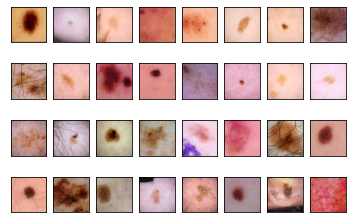

In [8]:
plt.rcParams["axes.grid"] = False
plt.figure(figsize=(6,6))
f, axarr = plt.subplots(4,8)
count = 0
for i in range(4):
    for j in range(8):
        axarr[i, j].imshow(images_batch[count]); plt.grid(False); count+=1
        axarr[i, j].set_xticks([])
        axarr[i, j].set_yticks([])

In [9]:
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
    latent_loss = tf.reduce_sum(tf.exp(logsigma)+mu**2-1-logsigma, axis=1)*0.5
    reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1, 2, 3))
    vae_loss = kl_weight*latent_loss+reconstruction_loss
    return vae_loss

In [10]:
n_filters=12
def make_standard_classifier(n_outputs=1):
    model = tf.keras.Sequential()
    model.add(L.Conv2D(filters=1*n_filters, kernel_size=5, 
                       strides=2, padding='same', activation='relu'))
    model.add(L.BatchNormalization())

    model.add(L.Conv2D(filters=2*n_filters, kernel_size=5, 
                       strides=2, padding='same', activation='relu'))
    model.add(L.BatchNormalization())

    model.add(L.Conv2D(filters=4*n_filters, kernel_size=5, 
                       strides=2, padding='same', activation='relu'))
    model.add(L.BatchNormalization())

    model.add(L.Conv2D(filters=6*n_filters, kernel_size=5, 
                       strides=2, padding='same', activation='relu'))
    model.add(L.BatchNormalization())

    model.add(L.Conv2D(filters=8*n_filters, kernel_size=5, 
                       strides=2, padding='same', activation='relu'))
    model.add(L.BatchNormalization())

    model.add(L.Flatten())
    model.add(L.Dense(512))
    model.add(L.Dense(n_outputs, activation=None))
    return model

In [11]:
def sampling(z_mean, z_logsigma):
    # By default, random.normal is "standard" (ie. mean=0 and std=1.0)
    batch, latent_dim = z_mean.shape
    epsilon = tf.random.normal(shape=(batch, latent_dim))
    z = z_mean+tf.exp(0.5*z_logsigma)*epsilon
    return z

In [12]:
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):

    vae_loss = vae_loss_function(x, x_pred, mu, logsigma) 
    classification_loss = tf.nn.weighted_cross_entropy_with_logits(y, y_logit, 2.0)

#     face_indicator = tf.cast(tf.equal(y, 1), tf.float32)

#     total_loss = classification_loss+face_indicator*vae_loss
    total_loss = classification_loss+vae_loss

    return total_loss, classification_loss

In [13]:
n_filters = 12 
latent_dim = 100 
def make_face_decoder_network():

    decoder = tf.keras.Sequential([
    L.Dense(units=8*8*8*n_filters, activation='relu'),  
    L.Reshape(target_shape=(8, 8, 8*n_filters)),

    L.Conv2DTranspose(filters=6*n_filters, kernel_size=5,  strides=2, padding='same', activation='relu'),
    L.Conv2DTranspose(filters=4*n_filters, kernel_size=5,  strides=2, padding='same', activation='relu'),
    L.Conv2DTranspose(filters=2*n_filters, kernel_size=5,  strides=2, padding='same', activation='relu'),
    L.Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2, padding='same', activation='relu'),
    L.Conv2DTranspose(filters=3, kernel_size=5,  strides=2, padding='same', activation='relu'),
    ])

    return decoder

In [14]:
class DB_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(DB_VAE, self).__init__()
    self.latent_dim = latent_dim

    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = make_standard_classifier(num_encoder_dims)
    self.decoder = make_face_decoder_network()

  def encode(self, x):
    encoder_output = self.encoder(x)

    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    z_mean = encoder_output[:, 1:self.latent_dim+1] 
    z_logsigma = encoder_output[:, self.latent_dim+1:]

    return y_logit, z_mean, z_logsigma

  def reparameterize(self, z_mean, z_logsigma):
    z = sampling(z_mean, z_logsigma)
    return z

  def decode(self, z):
    reconstruction = self.decoder(z)
    return reconstruction

  def call(self, x): 
    y_logit, z_mean, z_logsigma = self.encode(x)

    z = self.reparameterize(z_mean, z_logsigma)

    recon = self.decode(z)
    return y_logit, z_mean, z_logsigma, recon

  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit

dbvae = DB_VAE(latent_dim)


In [15]:
def get_latent_mu(images, dbvae, batch_size=1024):
  N = images.shape[0]
  mu = np.zeros((N, latent_dim))
  for start_ind in range(0, N, batch_size):
    end_ind = min(start_ind+batch_size, N+1)
    batch = (images[start_ind:end_ind]).astype(np.float32)#/255.
    _, batch_mu, _ = dbvae.encode(batch)
    mu[start_ind:end_ind] = batch_mu
  return mu

In [16]:
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=SMOOTHING_FAC): 
    print("Recomputing the sampling probabilities")
    
    mu = get_latent_mu(images, dbvae) 

    # sampling probabilities for the images
    training_sample_p = np.zeros(mu.shape[0])
    
    # consider the distribution for each latent variable 
    for i in range(latent_dim):
      
        latent_distribution = mu[:,i]
        # generate a histogram of the latent distribution
        hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)
#         if i == 4:
#             break
#             print(len(latent_distribution))
#         plt.hist(latent_distribution, bin_edges)
#         plt.show()
        
        # find which latent bin every data sample falls in 
        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')
        
        bin_idx = np.digitize(latent_distribution, bin_edges) 
        
        # smooth the density function
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)
        
        # invert the density function 
        inverse_heights = np.array([1/h for h in hist_smoothed_density])
#         print(inverse_heights/np.sum(inverse_heights))
        
        p = 1.0/(hist_smoothed_density[bin_idx-1])
#         print(len(p))
        
        # normalize all probabilities
        p = p/np.sum(p)
        
        # update sampling probabilities by considering whether the newly
        #     computed p is greater than the existing sampling probabilities.
        training_sample_p = np.maximum(p, training_sample_p)
        
    # final normalization
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p

In [17]:
import IPython

Starting epoch 25/25
Recomputing the sampling probabilities


  0%|          | 0/36 [00:00<?, ?it/s]

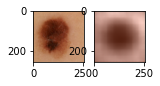

100%|██████████| 36/36 [00:01<00:00, 26.25it/s]


In [18]:
batch_size = 32
learning_rate = 5e-4
latent_dim = 100

num_epochs = LATENT_EPOCHS 

# instantiate a new DB-VAE model and optimizer
dbvae = DB_VAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate)


@tf.function
def debiasing_train_step(x, y):

  with tf.GradientTape() as tape:
    # Feed input x into dbvae. Note that this is using the DB_VAE call function!
    y_logit, z_mean, z_logsigma, x_recon = dbvae(x)
    
        
        # Compute the loss
    loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma) # TODO

  grads = tape.gradient(loss, dbvae.trainable_variables) 

  # apply gradients to variables
  optimizer.apply_gradients(zip(grads, dbvae.trainable_variables))
  return loss

# get training faces from data loader
all_faces = images[pos_train_inds]
all_non_faces = images[neg_train_inds]
if hasattr(tqdm, '_instances'): tqdm._instances.clear() 

# The training loop -- outer loop iterates over the number of epochs
for i in range(num_epochs):

  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, num_epochs))

  # Recompute data sampling proabilities
  '''TODO: recompute the sampling probabilities for debiasing'''
  p_faces = get_training_sample_probabilities(all_faces, dbvae) # TODO
#   p_neg = get_training_sample_probabilities(all_non_faces, dbvae)
  # get a batch of training data and compute the training step
  for j in tqdm(range(n_train_samples // batch_size)):
    # load a batch of data
    (x, y) = get_batch(batch_size, p_pos=p_faces)
    # loss optimization
    loss = debiasing_train_step(x, y)
    # plot the progress every 200 steps
    if j % 500 == 0: 
      mdl.util.plot_sample(x, y, dbvae)

In [19]:
dbvae.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 128, 128, 12)      912       
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 128, 12)      48        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 24)        7224      
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 64, 24)        96        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 48)        28848     
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 48)        192       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 72)       

In [20]:
class_model = dbvae.encoder
class_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 128, 128, 12)      912       
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 128, 12)      48        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 24)        7224      
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 64, 24)        96        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 48)        28848     
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 48)        192       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 72)       

In [21]:
class_model.add(L.Lambda(lambda output: tf.sigmoid(tf.expand_dims(output[:, 0], -1))))
class_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 128, 128, 12)      912       
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 128, 12)      48        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 24)        7224      
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 64, 24)        96        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 48)        28848     
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 48)        192       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 72)       

In [22]:
class SigmoidToSoftmax(tf.keras.layers.Layer):
    def __init__(self, units=2):
        super(SigmoidToSoftmax, self).__init__()
        self.units = units
    
    def build(self, input_shape):
        ones_init = tf.ones_initializer()
        self.ones = tf.Variable(name='ones',
                          initial_value=ones_init(shape=(input_shape[-1], 1),
                          dtype='float32'), trainable=True)
        
    def call(self, inputs):
        benign = tf.subtract(self.ones, inputs)
        return tf.concat([benign, inputs], -1)

In [23]:
newLayer = SigmoidToSoftmax()
sample_input = np.array([[0.5], [0.75], [0.34]])
newLayer(sample_input)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0.5       , 0.5       ],
       [0.25      , 0.75      ],
       [0.65999997, 0.34      ]], dtype=float32)>

In [24]:
newLayer.variables

[<tf.Variable 'sigmoid_to_softmax/ones:0' shape=(1, 1) dtype=float32, numpy=array([[1.]], dtype=float32)>]

In [25]:
(batch_x, batch_y) = get_batch(1000)

In [26]:
class_model.predict(batch_x)

array([[4.12509078e-03],
       [4.04588401e-01],
       [3.18104704e-03],
       [4.65337217e-01],
       [9.58677009e-03],
       [3.18611450e-02],
       [4.41116840e-03],
       [2.21087843e-01],
       [4.26877569e-03],
       [4.80640344e-02],
       [5.73417664e-01],
       [5.20666301e-01],
       [5.41788852e-03],
       [1.01148367e-01],
       [6.19682707e-02],
       [6.94318593e-01],
       [5.02905110e-03],
       [7.33427525e-01],
       [1.13910720e-01],
       [4.45548072e-03],
       [5.22482574e-01],
       [2.58214418e-02],
       [3.27958226e-01],
       [1.92145929e-01],
       [6.14851154e-03],
       [7.18874335e-01],
       [4.34934497e-01],
       [1.77710786e-01],
       [4.47644144e-01],
       [1.60680562e-01],
       [2.68392146e-01],
       [4.06716624e-03],
       [4.99651022e-02],
       [2.19069645e-01],
       [1.28490239e-01],
       [2.21764550e-01],
       [1.24489419e-01],
       [3.88072543e-02],
       [1.74719449e-02],
       [8.79570562e-03],


In [27]:
final_model = tf.keras.Sequential()
final_model.add(class_model)
final_model.add(SigmoidToSoftmax())

In [28]:
output = final_model.predict(batch_x)

In [29]:
output

array([[0.9958749 , 0.00412509],
       [0.5954116 , 0.4045884 ],
       [0.99681896, 0.00318105],
       ...,
       [0.92834723, 0.07165277],
       [0.72197586, 0.27802414],
       [0.15459728, 0.8454027 ]], dtype=float32)

In [30]:
final_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 1)                 3546713   
_________________________________________________________________
sigmoid_to_softmax_1 (Sigmoi (None, 2)                 1         
Total params: 3,546,714
Trainable params: 3,546,210
Non-trainable params: 504
_________________________________________________________________


In [31]:
preds = np.argmax(output, axis=-1)

In [32]:
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

In [33]:
truth = [val[0] for val in batch_y]

In [34]:
truth[-5:]

[1.0, 1.0, 1.0, 1.0, 1.0]

In [35]:
#check accuracy of the final_model
correct = [1 for tru, pred in zip(truth, preds) if tru==pred]
print(f'Accuracy: {len(correct)/len(preds) * 100}')

Accuracy: 78.0


In [36]:
RPS_SAVED_MODEL = "rps_saved_model"

In [37]:
tf.saved_model.save(final_model,RPS_SAVED_MODEL)

In [38]:
%%bash -s $RPS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['sequential_2_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 256, 256, 3)
      name: serving_default_sequential_2_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['sigmoid_to_softmax_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 2)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


2021-03-31 13:05:33.517765: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2
2021-03-31 13:05:33.520000: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2


In [39]:
loaded = tf.saved_model.load(RPS_SAVED_MODEL)

In [40]:

print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'sequential_2_input': TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='sequential_2_input')})
{'sigmoid_to_softmax_1': TensorSpec(shape=(None, 2), dtype=tf.float32, name='sigmoid_to_softmax_1')}


In [41]:

# Intialize the TFLite converter to load the SavedModel
# YOUR CODE HERE
converter = tf.lite.TFLiteConverter.from_saved_model(RPS_SAVED_MODEL)

# Set the optimization strategy for 'size' in the converter 
# YOUR CODE HERE
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Use the tool to finally convert the model
# YOUR CODE HERE
tflite_model = converter.convert()

In [42]:
tflite_model_file = 'latentnet_25epochs_83acc.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)